In [ ]:
"""Peter Mankowski
    https://github.com/petermankowski510
    Feb, 2023
"""

In [1]:
!curl -O https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
!curl -O https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  755M    0  223k    0     0   191k      0  1:07:24  0:00:01  1:07:23  191k
  2  755M    2 17.2M    0     0  8215k      0  0:01:34  0:00:02  0:01:32 8215k
  5  755M    5 45.1M    0     0  14.3M      0  0:00:52  0:00:03  0:00:49 14.3M
  9  755M    9 71.2M    0     0  17.1M      0  0:00:43  0:00:04  0:00:39 17.1M
 13  755M   13 99.7M    0     0  19.3M      0  0:00:38  0:00:05  0:00:33 20.1M
 16  755M   16  125M    0     0  20.4M      0  0:00:36  0:00:06  0:00:30 25.1M
 20  755M   20  153M    0     0  21.4M      0  0:00:35  0:00:07  0:00:28 27.2M
 23  755M   23  180M    0     0  22.0M      0  0:00:34  0:00:08  0:00:26 26.8M
 27  755M   27  207M    0     0  22.6M      0  0:00

In [2]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7391
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


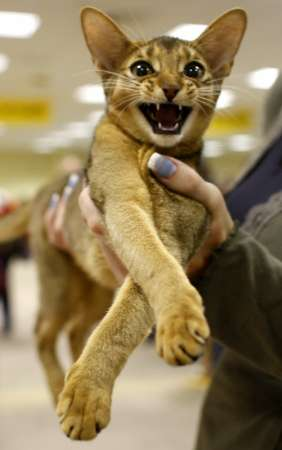

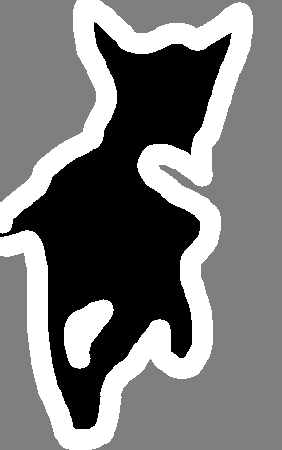

In [4]:
"""What does one input image and corresponding segmentation mask look like?"""

from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps

# Display input image imnum
imnum=11
display(Image(filename=input_img_paths[imnum]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[imnum]))
display(img)

In [5]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y

In [6]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 10, 10, 256)  590080     ['activation_7[0][0]']           
 ose)                                                                                             
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 10, 10, 256)  1024       ['conv2d_transpose[0][0]']       
 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 10, 10, 256)  0           ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_transpose_1 (Conv2DTran  (None, 10, 10, 256)  590080     ['activation_8[0][0]']           
 spose)   

                                                                                                  
 conv2d_transpose_7 (Conv2DTran  (None, 80, 80, 32)  9248        ['activation_14[0][0]']          
 spose)                                                                                           
                                                                                                  
 batch_normalization_14 (BatchN  (None, 80, 80, 32)  128         ['conv2d_transpose_7[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 up_sampling2d_7 (UpSampling2D)  (None, 160, 160, 64  0          ['add_5[0][0]']                  
                                )                                                                 
                                                                                                  
 up_sampli

In [7]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [8]:
# Configure the model for training.
# Use the "sparse" version of categorical_crossentropy because the target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
199/199 [==============================] - 540s 3s/step - loss: 1.0839 - val_loss: 1.8721
Epoch 2/15
199/199 [==============================] - 518s 3s/step - loss: 0.7657 - val_loss: 1.2070
Epoch 3/15
199/199 [==============================] - 506s 3s/step - loss: 0.7505 - val_loss: 0.7466
Epoch 4/15
199/199 [==============================] - 515s 3s/step - loss: 0.7402 - val_loss: 0.7378
Epoch 5/15
199/199 [==============================] - 476s 2s/step - loss: 0.7314 - val_loss: 0.7385
Epoch 6/15
199/199 [==============================] - 476s 2s/step - loss: 0.7179 - val_loss: 0.7632
Epoch 7/15
199/199 [==============================] - 477s 2s/step - loss: 0.6990 - val_loss: 0.7725
Epoch 8/15
199/199 [==============================] - 467s 2s/step - loss: 0.6689 - val_loss: 0.8512
Epoch 9/15
199/199 [==============================] - 472s 2s/step - loss: 0.6354 - val_loss: 0.8224
Epoch 10/15
199/199 [==============================] - 468s 2s/step - loss: 0.6004 - val_lo

31/31 [==============================] - 23s 717ms/step


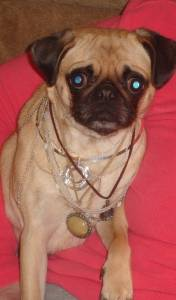

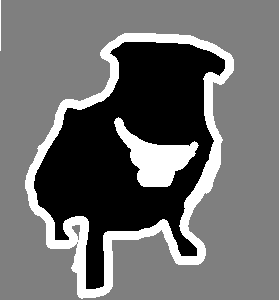

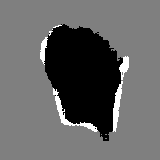

In [9]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

In [10]:
"""Saving mode/weights again - testing only

from keras.models import load_model
model.save("UNet_self1.h5")"""

In [11]:
"""Load pre-train model"""
from keras.models import load_model
loaded_model = load_model("oxford_segmentation.h5")

31/31 [==============================] - 23s 710ms/step


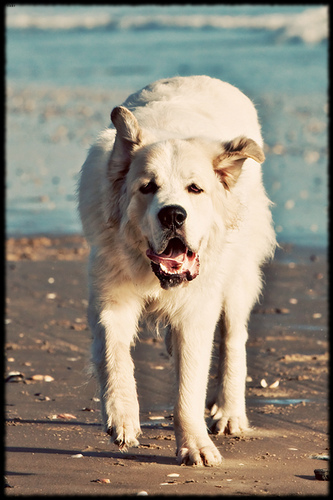

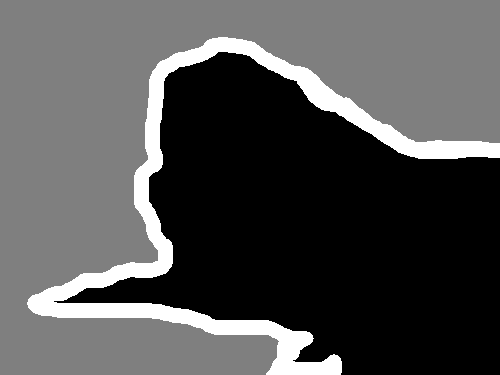

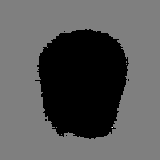

In [13]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = loaded_model.predict(val_gen)

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

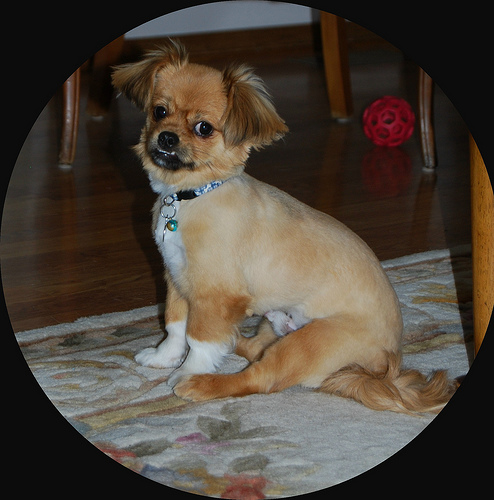

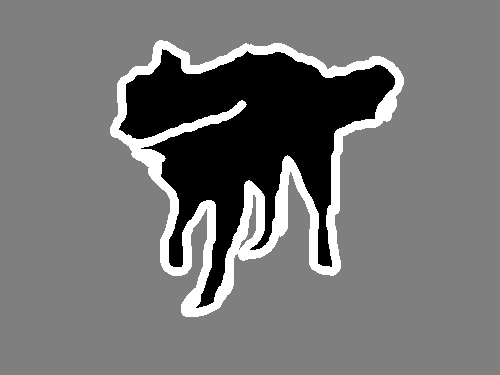

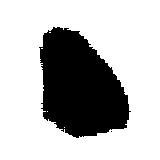

In [16]:
# Display results for validation image #10
i = 12

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.